In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fftpack import fft
from statsmodels.tsa.stattools import acf
import pandas as pd
import os

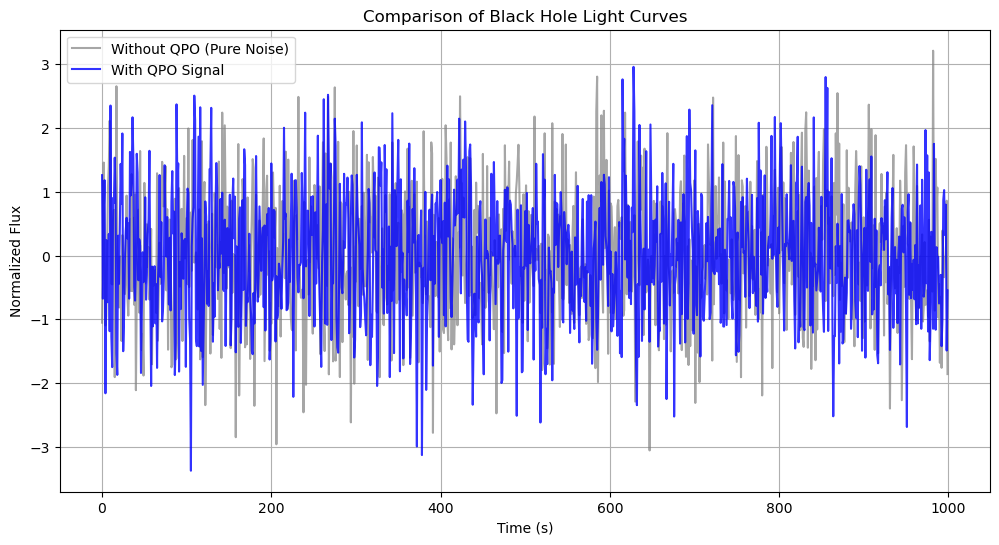

In [2]:
# Parameters
mean = 0
std = 0.5
duration = 1000  # Length of the time series
dt = 1

def simulate_black_hole_lightcurve(duration=duration, dt=1, qpo_freq=0.03, qpo_amplitude=1, noise_level=0.2, include_qpo=True):
    """
    Simulate a light curve with stochastic noise + periodic signal (QPO). 
    """
    # Time array
    t = np.arange(0, duration, dt)
    
    # White noise (Gaussian)
    white_noise = np.random.normal(mean, std, size=len(t))

    # exponetiate
    # white_noise = np.exp(white_noise)

    # QPO signal (damped sinusoid)
    qpo = qpo_amplitude * np.sin(2 * np.pi * qpo_freq * t) * np.exp(-0.001 * t) if include_qpo else 0
    
    # Combine noise and QPO signal
    flux = white_noise + qpo
    
    # Normalize
    flux = (flux - np.mean(flux)) / np.std(flux)
    
    return t, flux

# Generate datasets
t, flux_with_qpo = simulate_black_hole_lightcurve(qpo_freq=0.15, qpo_amplitude=0.5, include_qpo=True)
_, flux_without_qpo = simulate_black_hole_lightcurve(include_qpo=False)

# Plot both datasets
plt.figure(figsize=(12, 6))

plt.plot(t, flux_without_qpo, color='gray', alpha=0.7, label="Without QPO (Pure Noise)")
plt.plot(t, flux_with_qpo, color='b', alpha=0.8, label="With QPO Signal")

plt.xlabel("Time (s)")
plt.ylabel("Normalized Flux")
plt.title("Comparison of Black Hole Light Curves")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 640x480 with 0 Axes>

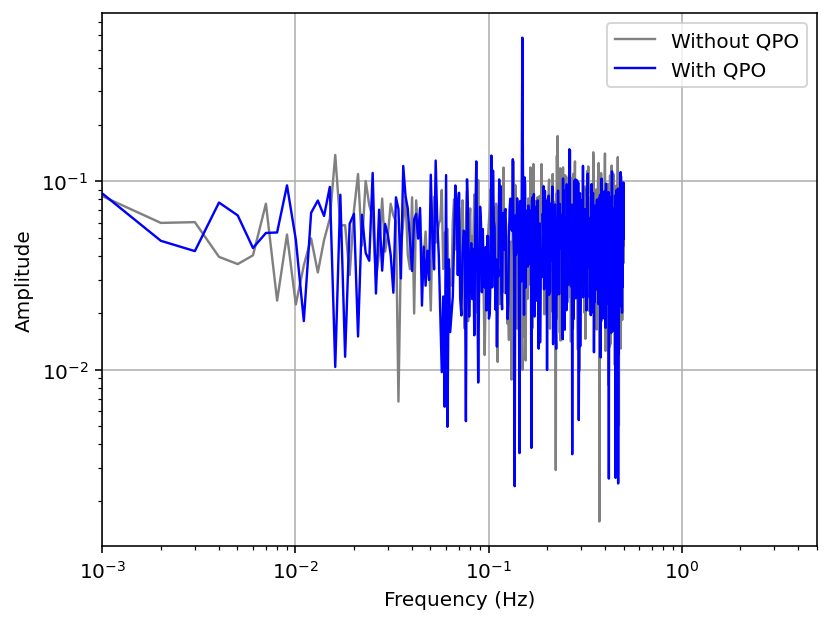

In [3]:
# Number of sample points
N = 1000
N = int(N)
T = 1.0  # Sample spacing (time step)

# Set up an array of times
x = np.linspace(0.0, N*T, N)

# Compute FFT for both cases
yf_with_qpo = fft(flux_with_qpo[:N]) 
yf_without_qpo = fft(flux_without_qpo[:N])

# Compute Periodograms
per_with_qpo = (2.0 / N) * (np.abs(yf_with_qpo[1:int(N/2)]))
per_without_qpo = (2.0 / N) * (np.abs(yf_without_qpo[1:int(N/2)]))

# Create Fourier frequency array
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2)-1)

# Plot the Periodograms
plt.figure(1)
fig, ax = plt.subplots(dpi=144)

plt.plot(xf, per_without_qpo, linewidth=1.2, color="gray", label="Without QPO")
plt.plot(xf, per_with_qpo, linewidth=1.2, color="b", label="With QPO")

plt.xlim(0.001, 5.0)  # Zoom in
plt.xlabel(r'Frequency (Hz)', fontsize=10)
plt.ylabel(r'Amplitude', fontsize=10)

ax.set_yscale('log')
ax.set_xscale('log')

plt.legend()
plt.grid(True)
plt.show()

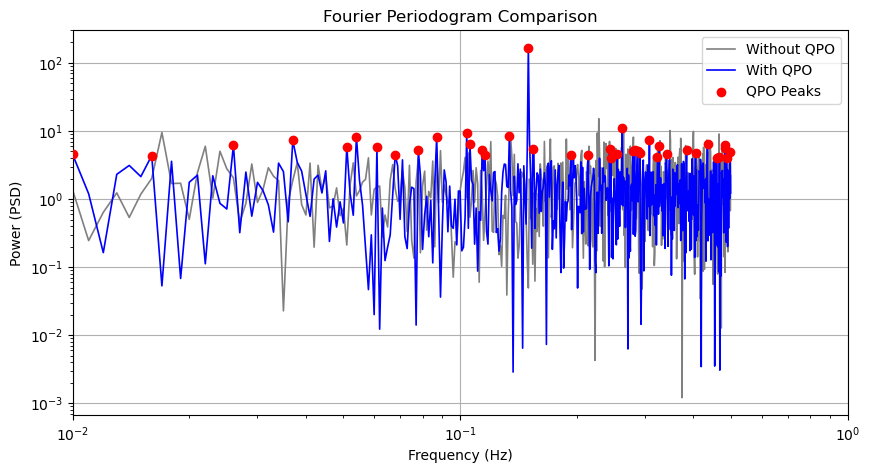

In [4]:
# Number of sample points
N = len(flux_with_qpo)
T = 1.0  # Sample spacing (time step)

# Compute FFT for both cases
yf_with_qpo = fft(flux_with_qpo)
yf_without_qpo = fft(flux_without_qpo)

# Compute Periodograms
per_with_qpo = (2.0 / N) * (np.abs(yf_with_qpo[1:int(N/2)]) ** 2)  
per_without_qpo = (2.0 / N) * (np.abs(yf_without_qpo[1:int(N/2)]) ** 2)  

# Create Fourier frequency array
xf = np.fft.fftfreq(N, T)[1:int(N/2)]  

# Identify peaks in the power spectrum
peaks_with_qpo, _ = find_peaks(per_with_qpo, height=np.mean(per_with_qpo) * 2)

# Plot the Periodograms
plt.figure(figsize=(10, 5))
plt.plot(xf, per_without_qpo, linewidth=1.2, color="gray", label="Without QPO")
plt.plot(xf, per_with_qpo, linewidth=1.2, color="b", label="With QPO")
plt.scatter(xf[peaks_with_qpo], per_with_qpo[peaks_with_qpo], color='r', label="QPO Peaks", zorder=3)

plt.xlim(0.01, 1.0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (PSD)")
plt.title("Fourier Periodogram Comparison")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)

plt.show()

<!-- Fourier Power Spectrum (Periodogram):
The plot displays the power spectrum with detected QPO peaks marked in red.
The log-log scale allows for better visibility of spectral features.
Autocorrelation Function (ACF):
The autocorrelation function shows oscillatory behavior, indicating periodicity.
The damping in oscillations suggests a quasi-periodic rather than perfectly periodic signal.

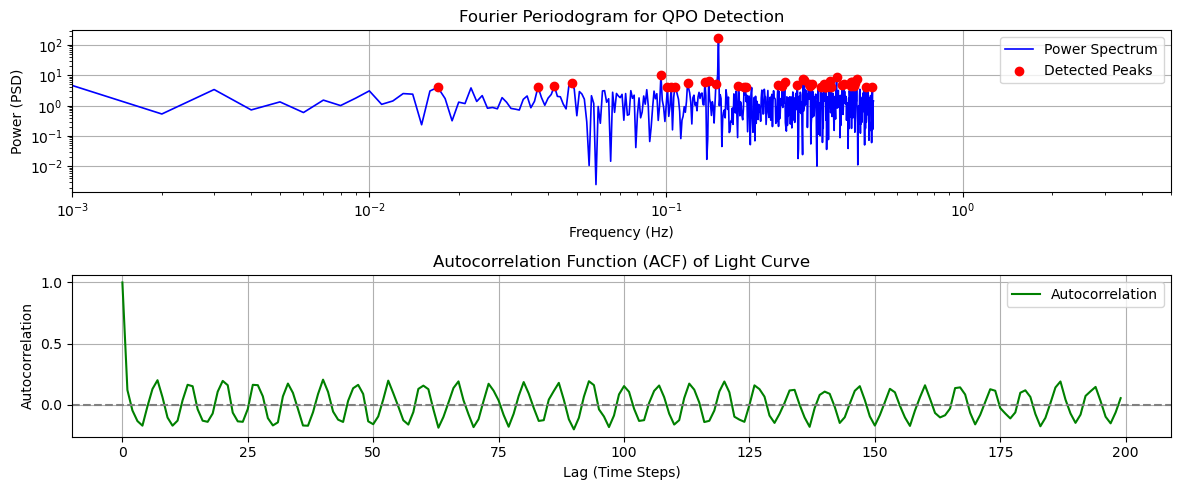

Detected QPO frequencies (Hz): [0.017 0.037 0.042 0.048 0.096 0.101 0.104 0.107 0.118 0.135 0.139 0.147
 0.15  0.175 0.183 0.185 0.238 0.246 0.251 0.276 0.289 0.292 0.302 0.305
 0.31  0.331 0.339 0.342 0.344 0.346 0.356 0.36  0.375 0.391 0.397 0.418
 0.42  0.424 0.428 0.434 0.438 0.471 0.495]
✔ QPO detected close to expected frequency (0.15 Hz): [0.135, 0.139, 0.147, 0.15]


In [5]:
# Function to verify QPO presence in simulated light curve
def verify_qpo_simulation(t, flux, qpo_freq_expected=None):
    """
    Verify the presence of a QPO in a simulated light curve using multiple methods:
    1. Fourier Power Spectrum (Periodogram)
    2. Autocorrelation Function (ACF)
    
    Parameters:
    - t: Time array
    - flux: Simulated light curve
    - qpo_freq_expected: Expected QPO frequency for reference (if known)
    
    Returns:
    - Plots of Power Spectrum and Autocorrelation Function
    """

    # Number of sample points
    N = len(flux)
    T = np.mean(np.diff(t))  # Calculate time step
    
    # Compute FFT
    yf = fft(flux)
    
    # Compute Periodogram (Power Spectral Density)
    per = (2.0 / N) * (np.abs(yf[1:int(N/2)]) ** 2)  

    # Create Fourier frequency array
    xf = np.fft.fftfreq(N, T)[1:int(N/2)]  

    # Identify peaks in the power spectrum
    peaks, properties = find_peaks(per, height=np.mean(per) * 2)  # Peak threshold: 2x mean power

    # Compute Autocorrelation Function (ACF)
    lag_values = np.arange(0, 200, 1)  # Compute ACF for 200 lags
    acf_values = acf(flux, nlags=199, fft=True)

    # Plot Power Spectrum (Periodogram)
    plt.figure(figsize=(12, 5))

    plt.subplot(2, 1, 1)
    plt.plot(xf, per, linewidth=1.2, color="b", label="Power Spectrum")                 
    plt.scatter(xf[peaks], per[peaks], color='r', label="Detected Peaks", zorder=3)  # Mark detected peaks

    plt.xlim(0.001, 5.0)  # Zoom in for QPO range
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (PSD)")
    plt.title("Fourier Periodogram for QPO Detection")

    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.grid(True)

    # Plot Autocorrelation Function (ACF)
    plt.subplot(2, 1, 2)
    plt.plot(lag_values, acf_values, color='g', label="Autocorrelation")
    plt.axhline(0, linestyle="--", color="gray")  # Reference line at 0
    plt.xlabel("Lag (Time Steps)")
    plt.ylabel("Autocorrelation")
    plt.title("Autocorrelation Function (ACF) of Light Curve")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print detected QPO peaks for reference
    print("Detected QPO frequencies (Hz):", xf[peaks])

    if qpo_freq_expected:
        close_peaks = [freq for freq in xf[peaks] if np.isclose(freq, qpo_freq_expected, atol=0.02)]
        if close_peaks:
            print(f"✔ QPO detected close to expected frequency ({qpo_freq_expected} Hz):", close_peaks)
        else:
            print(f"❌ No strong QPO detected near {qpo_freq_expected} Hz. Consider rechecking parameters.")

# Example Usage: Validate QPO in a simulated light curve
t, flux_with_qpo = simulate_black_hole_lightcurve(qpo_freq=0.15, qpo_amplitude=0.5, include_qpo=True)
verify_qpo_simulation(t, flux_with_qpo, qpo_freq_expected=0.15)


In [7]:
# Define folder to save dataset
DATASET_FOLDER = "qpo_dataset"
os.makedirs(DATASET_FOLDER, exist_ok=True)  # Create folder if it doesn't exist

# Function to create sequences from time-series data
def create_sequences(data, seq_length, stride=10):
    """
    Extracts sequences from a given time-series data with reduced similarity.
    
    Parameters:
    - data: 1D NumPy array (time series)
    - seq_length: Length of each sequence
    - stride: Step size to reduce overlap between sequences
    
    Returns:
    - sequences: Extracted sequences with reduced similarity
    """
    
    sequences = []
    for i in range(0,len(data) - seq_length,stride):
        seq = data[i:i+seq_length]
        seq = (seq - np.mean(seq)) / np.std(seq)  # Normalize each sequence individually
        sequences.append(seq)
    return np.array(sequences)

# Function to generate QPO dataset and save in multiple CSV files
def generate_labeled_qpo_dataset(num_samples=1000, seq_length=100, batch_size=50):
    """
    Generates QPO light curves and saves them in multiple CSV files inside a folder.

    Parameters:
    - num_samples: Total number of light curves to generate
    - seq_length: Length of each time-series segment
    - batch_size: Number of light curves per CSV file
    """
    file_count = 1
    for i in range(0, num_samples, batch_size):
        dataset = []
        labels = [] # 1 for QPO, 0 for non-QPO

        for _ in range(batch_size):
            qpo_freq = np.random.uniform(0.01, 1)  # Random QPO frequency

            # changing the amp to little range
            qpo_amp = np.random.uniform(0.6,1)  # Random QPO amplitude
            _, flux_qpo = simulate_black_hole_lightcurve(qpo_freq=qpo_freq, qpo_amplitude=qpo_amp)
            sequences_qpo = create_sequences(flux_qpo, seq_length)
            dataset.extend(sequences_qpo)
            labels.extend([1] * len(sequences_qpo))

            # Generate Non-QPO sequences
            _, flux_non_qpo = simulate_black_hole_lightcurve(qpo_freq=qpo_freq, qpo_amplitude=qpo_amp, include_qpo=False)
            sequences_non_qpo = create_sequences(flux_non_qpo, seq_length, stride=10)
            dataset.extend(sequences_non_qpo)
            labels.extend([0] * len(sequences_non_qpo))


        df = pd.DataFrame(dataset)
        df['label'] = labels  
        filename = os.path.join(DATASET_FOLDER, f"labeled_qpo_data_{file_count}.csv")
        df.to_csv(filename, index=False)
        print(f"Saved {len(dataset)} sequences to {filename}")
        file_count += 1

# Run dataset generation (split into multiple files)
generate_labeled_qpo_dataset()

Saved 9000 sequences to qpo_dataset/labeled_qpo_data_1.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_2.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_3.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_4.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_5.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_6.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_7.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_8.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_9.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_10.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_11.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_12.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_13.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_14.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_15.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_data_16.csv
Saved 9000 sequences to qpo_dataset/labeled_qpo_d

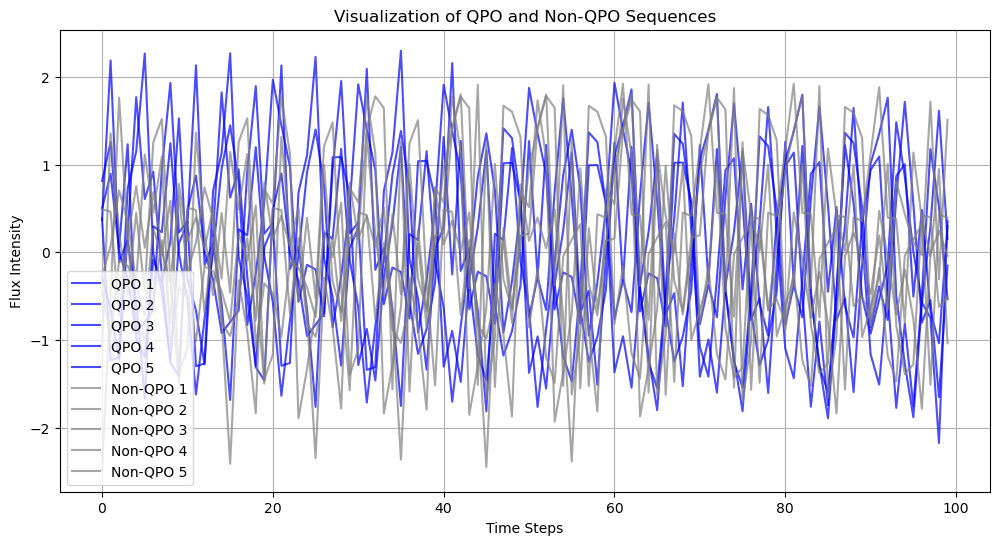

In [12]:
# Updated function to visualize both QPO and Non-QPO sequences in a balanced way
def visualize_qpo_file_balanced(filename, num_samples=5):
    """
    Visualizes both QPO and Non-QPO sequences from a saved CSV file, ensuring equal representation.

    Parameters:
    - filename: Path to the CSV file
    - num_samples: Number of sequences to visualize for each class (QPO and Non-QPO)
    """
    # Load data
    df = pd.read_csv(filename)

    # Extract labels and sequences
    labels = df["label"].values  # Extract labels
    sequences = df.drop(columns=["label"]).values  # Remove labels column

    # Separate QPO and Non-QPO sequences
    qpo_sequences = sequences[labels == 1]
    non_qpo_sequences = sequences[labels == 0]

    # Ensure we have enough samples for both categories
    num_qpo_samples = min(num_samples, len(qpo_sequences))
    num_non_qpo_samples = min(num_samples, len(non_qpo_sequences))

    plt.figure(figsize=(12, 6))

    # Plot QPO sequences
    for i in range(num_qpo_samples):
        plt.plot(qpo_sequences[i], label=f"QPO {i+1}", color="blue", alpha=0.7)

    # Plot Non-QPO sequences
    for i in range(num_non_qpo_samples):
        plt.plot(non_qpo_sequences[i], label=f"Non-QPO {i+1}", color="gray", alpha=0.7)

    plt.xlabel("Time Steps")
    plt.ylabel("Flux Intensity")
    plt.title("Visualization of QPO and Non-QPO Sequences")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage: Ensure that QPO and Non-QPO sequences are balanced
visualize_qpo_file_balanced("qpo_dataset/labeled_qpo_data_1.csv")
